<a href="https://colab.research.google.com/github/ahmedrana603/NLP-Language-Modeling-for-Urdu-News-Articles/blob/main/Language_Modeling_for_Urdu_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART 1 - BBC Urdu Dataset Collection and Preprocessing**

# **Importing Libraries**

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re

# **Base URL**

In [2]:
base_url = "https://www.bbc.com/urdu/topics/cjgn7n9zzq7t"

article_links = set()
raw_articles = []
metadata_list = []

# **Collecting Article Links**

In [3]:

for page in range(1, 50):
    url = f"{base_url}?page={page}"
    res = requests.get(url)
    soup = BeautifulSoup(res.text, "html.parser")

    for a in soup.select("h2 a[href*='/urdu/articles/']"):
        href = a["href"]
        if href.startswith("/"):
            href = "https://www.bbc.com" + href
        article_links.add(href)

    if len(article_links) >= 270:
        break

article_links = list(article_links)[:270]


# **Scrapping Articles**

In [4]:
for idx, link in enumerate(article_links, 1):
    res = requests.get(link)
    soup = BeautifulSoup(res.text, "html.parser")

    title_tag = soup.find("h1", class_="article-heading")
    title = title_tag.get_text(strip=True) if title_tag else "No title found"

    date_tag = soup.find("time")
    date = date_tag.get_text(strip=True) if date_tag else "No date found"

    author_tag = soup.find("span", class_="byline__name")
    author = author_tag.get_text(strip=True) if author_tag else "BBC Urdu"

    category_tag = soup.find("a", class_="bbc-1f2hn8h e1hk9ate4")
    category = category_tag.get_text(strip=True) if category_tag else "Unknown"

    body_paragraphs = []

    article_tag = soup.find("article")
    if article_tag:
        for p in article_tag.find_all("p"):
            text = p.get_text(strip=True)
            if text.startswith("©") or "،تصویر کا ذریعہ" in text:
                continue
            body_paragraphs.append(text)

    if not body_paragraphs:
        for div in soup.find_all("div", class_=lambda x: x and "RichTextComponentWrapper" in x):
            for p in div.find_all("p"):
                text = p.get_text(strip=True)
                if text.startswith("©") or "،تصویر کا ذریعہ" in text:
                    continue
                body_paragraphs.append(text)

    if not body_paragraphs:
        for div in soup.find_all("div", {"dir": "rtl"}):
            for p in div.find_all("p"):
                text = p.get_text(strip=True)
                if len(text) > 5:
                    body_paragraphs.append(text)

    body = "\n".join(body_paragraphs).strip()


    raw_articles.append((idx, body))
    metadata_list.append({
        "article_id": idx,
        "title": title,
        "url": link,
        "category": category,
        "date": date,
        "author": author
    })

    time.sleep(0.5)


# **Txt File**

In [5]:
with open("raw.txt", "w", encoding="utf-8") as f:
    for idx, body in raw_articles:
        f.write(f"### Article {idx} ###\n")
        f.write(body + "\n\n")


# **Metadata JSON file**

In [6]:
with open("metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata_list, f, ensure_ascii=False, indent=2)


# **Diacritics Removal**

In [7]:

def remove_diacritics(text):
    """
    Removes Urdu diacritics (Aarabs) from text.
    Unicode ranges:
    064B–065F
    0670
    06D6–06ED
    """
    diacritics_pattern = r'[\u064B-\u065F\u0670\u06D6-\u06ED]'
    return re.sub(diacritics_pattern, '', text)


with open("raw.txt", "r", encoding="utf-8", errors='ignore') as f:
    raw_content = f.read()


cleaned_content = remove_diacritics(raw_content)


with open("no_diacritics.txt", "w", encoding="utf-8") as f:
    f.write(cleaned_content)


print("Diacritics removed successfully.")

Diacritics removed successfully.


# **Noise Removal**

# **Removal of Non-Urdu Text**

In [8]:
def remove_urls(text):
    """Remove URLs like http://... or www..."""
    url_pattern = r'http\S+|www\S+'
    return re.sub(url_pattern, '', text)

def remove_emojis(text):
    """Remove emojis"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub('', text)

def remove_english(text):
    """Remove English letters"""
    english_pattern = r'[A-Za-z]+'
    return re.sub(english_pattern, '', text)

def remove_navigation_text(text):
    """Remove common web/navigation phrases"""
    unwanted_phrases = [
        "مواد پر جائیں",
        "سبسکرائب کرنے کے لیے کلک کریں",
        "بی بی سی اردو کی خبروں اور فیچرز کو اپنے فون پر حاصل کریں",
        "اپنے فون پر حاصل کریں",
        "کلک کریں"
    ]
    for phrase in unwanted_phrases:
        text = text.replace(phrase, '')
    return text

def remove_noise(text):
    """Apply all noise removal rules"""
    text = remove_urls(text)
    text = remove_emojis(text)
    text = remove_english(text)
    text = remove_navigation_text(text)
    return text


def remove_non_urdu(text):
    """Keep only Urdu letters, digits, spaces, Urdu punctuation"""
    return re.sub(r'[^\u0600-\u06FF\s۔؟!،0-9]', '', text)


with open("no_diacritics.txt", "r", encoding="utf-8", errors='ignore') as f:
    content = f.read()

content = remove_noise(content)

split_articles = content.split("### Article ")
filtered_articles = []

for part in split_articles:
    if not part.strip():
        continue

    lines = part.split("\n", 1)
    header_num = lines[0].strip()
    header = f"### Article {header_num} ###"
    body = lines[1] if len(lines) > 1 else ""

    body = remove_non_urdu(body)

    filtered_articles.append(header + "\n" + body.strip() + "\n\n")

with open("urdu_only_filtered.txt", "w", encoding="utf-8") as f:
    f.writelines(filtered_articles)

print("Noise removed and non-Urdu text filtered. Article headers preserved. File ready: urdu_only_filtered.txt")

Noise removed and non-Urdu text filtered. Article headers preserved. File ready: urdu_only_filtered.txt


# **Sentence Segmentation**

In [9]:
input_file = "urdu_only_filtered.txt"
output_file = "segmented.txt"

with open(input_file, "r", encoding="utf-8") as f:
    content = f.read()

articles = re.split(r'(?=### Article \d+ ###)', content)

segmented_articles = []

for article in articles:
    article = article.strip()
    if not article:
        continue

    lines = article.split("\n", 1)
    header = lines[0].strip()
    body = lines[1] if len(lines) > 1 else ""


    body = re.sub(r'([۔؟!])\s*', r'\1\n', body)

    body = re.sub(r'\n+', '\n', body)

    body = body.strip()

    segmented_articles.append(header + "\n" + body + "\n\n")

with open(output_file, "w", encoding="utf-8") as f:
    f.writelines(segmented_articles)

print("Sentence segmentation complete. File saved as segmented.txt")


Sentence segmentation complete. File saved as segmented.txt


# **Whitespace and Formatting Normalization**

In [10]:
import re

input_file = "segmented.txt"
output_file = "normalized.txt"

def normalize_whitespace(text):
    lines = text.split('\n')
    cleaned_lines = []

    for line in lines:
        line = re.sub(r'\s+', ' ', line)

        line = line.strip()

        cleaned_lines.append(line)

    cleaned_text = '\n'.join([l for l in cleaned_lines if l])

    return cleaned_text


with open(input_file, "r", encoding="utf-8") as f:
    content = f.read()

articles = re.split(r'(?=### Article \d+ ###)', content)

normalized_articles = []

for article in articles:
    article = article.strip()
    if not article:
        continue

    parts = article.split("\n", 1)
    header = parts[0].strip()
    body = parts[1] if len(parts) > 1 else ""

    body = normalize_whitespace(body)

    normalized_articles.append(header + "\n" + body + "\n\n")

with open(output_file, "w", encoding="utf-8") as f:
    f.writelines(normalized_articles)

print("Whitespace and formatting normalization complete.")
print("File saved as normalized.txt")


Whitespace and formatting normalization complete.
File saved as normalized.txt


# **Custom Linguistic Processing**

In [11]:
import re

input_file = "normalized.txt"
output_file = "cleaned.txt"


def urdu_tokenizer(text, is_header=False):
    """
    Tokenizes Urdu text:
    - Replaces numbers with <NUM> only for body text
    - Separates punctuation
    """
    if not is_header:
        text = re.sub(r'\d+', '<NUM>', text)

    text = re.sub(r'([۔،؟!])', r' \1 ', text)

    text = re.sub(r'\s+', ' ', text).strip()

    tokens = text.split(" ")
    return tokens

lemmatizer_map = {
    "ہیں": "ہے",
    "تھیں": "تھا",
    "گئیں": "گیا",
    "کرتی": "کرتا"
}

def urdu_lemmatizer(word):
    """
    Rule-based lemmatizer for Urdu:
    - Handles plurals (وں, یں, ات)
    - Feminine → Masculine (ی → ا)
    - Handles irregular forms via dictionary
    """
    if word in lemmatizer_map:
        return lemmatizer_map[word]

    if word.endswith("وں") and len(word) > 3:
        return word[:-2]

    if word.endswith("یں") and len(word) > 3:
        return word[:-2]

    if word.endswith("ات") and len(word) > 3:
        return word[:-2]

    if word.endswith("ی") and len(word) > 3:
        return word[:-1] + "ا"

    return word


suffixes = [
    "وں", "یں", "ات", "یاں",
    "نے", "ہے", "ہوں"
]

def urdu_stemmer(word):
    """
    Light stemmer to reduce vocabulary without destroying sentence structure.
    """
    for suffix in sorted(suffixes, key=len, reverse=True):
        if word.endswith(suffix) and len(word) > len(suffix) + 1:
            return word[:-len(suffix)]
    return word


with open(input_file, "r", encoding="utf-8") as f:
    content = f.read()

articles = re.split(r'(?=### Article \d+ ###)', content)

processed_articles = []

for article in articles:
    article = article.strip()
    if not article:
        continue

    parts = article.split("\n", 1)
    header = parts[0].strip()
    body = parts[1] if len(parts) > 1 else ""

    sentences = body.split("\n")
    processed_sentences = []

    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence:
            continue

        tokens = urdu_tokenizer(sentence, is_header=False)
        tokens = [urdu_lemmatizer(tok) for tok in tokens]

        tokens = [urdu_stemmer(tok) for tok in tokens]

        processed_sentences.append(" ".join(tokens))

    processed_body = "\n".join(processed_sentences)

    processed_articles.append(header + "\n" + processed_body + "\n\n")

with open(output_file, "w", encoding="utf-8") as f:
    f.writelines(processed_articles)

print("Custom Tokenization, Lemmatization, and Light Stemming complete.")
print(f"File saved as {output_file}")


Custom Tokenization, Lemmatization, and Light Stemming complete.
File saved as cleaned.txt


# **Part 2 - BBC Style Urdu News Article Generation**

# **Language Model Training**

In [12]:

import re
import random
from collections import defaultdict, Counter
import math

print("Loading preprocessed dataset from cleaned.txt...")

with open("cleaned.txt", "r", encoding="utf-8") as f:
    content = f.read()

articles = content.split("### Article ")
all_tokens = []

for article in articles:
    if not article.strip():
        continue

    lines = article.split("\n", 1)
    if len(lines) > 1:
        body = lines[1].strip()
        tokens = body.split()
        all_tokens.extend(tokens)

print(f"Total tokens: {len(all_tokens)}")
print(f"Vocabulary size: {len(set(all_tokens))}")


Loading preprocessed dataset from cleaned.txt...
Total tokens: 435097
Vocabulary size: 12735


# **UNIGRAM Model + Smoothing**

In [13]:
from collections import Counter

class UnigramModel:

    def __init__(self, smoothing='add-k', k=0.1):
        self.unigram_counts = Counter()
        self.total_words = 0
        self.vocabulary = set()
        self.vocab_size = 0
        self.smoothing = smoothing
        self.k = 1.0 if smoothing == 'laplace' else k

    def train(self, tokens):
        self.unigram_counts = Counter(tokens)
        self.total_words = len(tokens)
        self.vocabulary = set(tokens)
        self.vocab_size = len(self.vocabulary)

    def get_probability(self, word):
        count = self.unigram_counts[word]
        numerator = count + self.k
        denominator = self.total_words + (self.k * self.vocab_size)
        return numerator / denominator


unigram_model = UnigramModel(smoothing='add-k', k=0.1)
unigram_model.train(all_tokens)

print("[UNIGRAM MODEL TRAINED]")
print("Vocabulary size:", unigram_model.vocab_size)

print("\nTop 10 unigrams:")
for word, count in unigram_model.unigram_counts.most_common(10):
    print(f"{word}: {count}")

unseen_word = "XYZ_UNSEEN_WORD"
prob = unigram_model.get_probability(unseen_word)
print(f"\nSmoothing Demo (Unseen Unigram):")
print(f"P({unseen_word}) = {prob:.10f}")


[UNIGRAM MODEL TRAINED]
Vocabulary size: 12735

Top 10 unigrams:
کے: 18692
۔: 14329
ہے: 13912
میں: 12638
کی: 12163
اور: 8555
سے: 8512
کہ: 8312
نے: 6477
کا: 6214

Smoothing Demo (Unseen Unigram):
P(XYZ_UNSEEN_WORD) = 0.0000002292


# **BIGRAM Model + Smoothing**

In [14]:
from collections import defaultdict, Counter

class BigramModel:

    def __init__(self, smoothing='add-k', k=0.1):
        self.bigram_counts = defaultdict(Counter)
        self.unigram_counts = Counter()
        self.vocabulary = set()
        self.vocab_size = 0
        self.smoothing = smoothing
        self.k = 1.0 if smoothing == 'laplace' else k

    def train(self, tokens):
        tokens = ['<START>'] + tokens + ['<END>']
        self.unigram_counts = Counter(tokens)
        self.vocabulary = set(tokens)
        self.vocab_size = len(self.vocabulary)
        for i in range(len(tokens)-1):
            w1, w2 = tokens[i], tokens[i+1]
            self.bigram_counts[w1][w2] += 1

    def get_probability(self, w1, w2):
        bigram_count = self.bigram_counts[w1][w2]
        unigram_count = self.unigram_counts[w1]
        numerator = bigram_count + self.k
        denominator = unigram_count + (self.k * self.vocab_size)
        return numerator / denominator

    def get_next_word_probabilities(self, w1):
        """
        Calculates the probability distribution for the next word given w1.
        """
        probabilities = {}
        for w2 in self.vocabulary:
            probabilities[w2] = self.get_probability(w1, w2)

        total_prob = sum(probabilities.values())
        if total_prob > 0:
            for w2 in probabilities:
                probabilities[w2] /= total_prob
        return probabilities


bigram_model = BigramModel(smoothing='add-k', k=0.1)
bigram_model.train(all_tokens)

print("[BIGRAM MODEL TRAINED]")
print("Vocabulary size:", bigram_model.vocab_size)

bigram_list = []
for w1 in bigram_model.bigram_counts:
    for w2 in bigram_model.bigram_counts[w1]:
        count = bigram_model.bigram_counts[w1][w2]
        bigram_list.append(((w1, w2), count))

bigram_list.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 bigrams:")
for bigram, count in bigram_list[:10]:
    print(f"{bigram}: {count}")

test_w1 = "پاکستان"
unseen_word = "XYZ_UNSEEN_WORD"
prob = bigram_model.get_probability(test_w1, unseen_word)
print(f"\nSmoothing Demo (Unseen Bigram):")
print(f"P({unseen_word} | {test_w1}) = {prob:.10f}")

[BIGRAM MODEL TRAINED]
Vocabulary size: 12737

Top 10 bigrams:
('ہے', '۔'): 5666
('ہے', 'کہ'): 3044
('کے', 'لیے'): 2032
('کے', 'مطابق'): 1332
('انھ', 'نے'): 1282
('تھا', 'کہ'): 1262
('ہے', 'اور'): 1189
('ان', 'کے'): 1185
('تھا', '۔'): 1162
('کا', 'کہنا'): 1149

Smoothing Demo (Unseen Bigram):
P(XYZ_UNSEEN_WORD | پاکستان) = 0.0000259155


# **TRIGRAM Model + Smoothing**

In [15]:
from collections import defaultdict, Counter

class TrigramModel:

    def __init__(self, bigram_model, smoothing='add-k', k=0.1):
        self.trigram_counts = defaultdict(lambda: defaultdict(Counter))
        self.bigram_context_counts = defaultdict(int)
        self.vocabulary = set()
        self.vocab_size = 0
        self.bigram_model = bigram_model
        self.smoothing = smoothing
        self.k = 1.0 if smoothing == 'laplace' else k

    def train(self, tokens):
        tokens = ['<START>', '<START>'] + tokens + ['<END>']
        self.vocabulary = set(tokens)
        self.vocab_size = len(self.vocabulary)
        for i in range(len(tokens)-2):
            w1, w2, w3 = tokens[i], tokens[i+1], tokens[i+2]
            self.trigram_counts[w1][w2][w3] += 1
            self.bigram_context_counts[(w1, w2)] += 1

    def get_probability(self, w1, w2, w3):
        trigram_count = self.trigram_counts[w1][w2][w3]
        context_count = self.bigram_context_counts[(w1, w2)]
        if context_count < 2:
            return self.bigram_model.get_probability(w2, w3)
        numerator = trigram_count + self.k
        denominator = context_count + (self.k * self.bigram_model.vocab_size)
        return numerator / denominator

    def get_next_word_probabilities(self, w1, w2):
        """
        Calculates the probability distribution for the next word given w1 and w2.
        Includes backoff to bigram model if trigram context count is too low.
        """
        probabilities = {}
        context_count = self.bigram_context_counts[(w1, w2)]

        if context_count < 2:
            probabilities = self.bigram_model.get_next_word_probabilities(w2)
        else:
            for w3 in self.bigram_model.vocabulary:
                trigram_count = self.trigram_counts[w1][w2][w3]
                numerator = trigram_count + self.k
                denominator = context_count + (self.k * self.bigram_model.vocab_size)
                probabilities[w3] = numerator / denominator

        total_prob = sum(probabilities.values())
        if total_prob > 0:
            for w3 in probabilities:
                probabilities[w3] /= total_prob
        return probabilities


trigram_model = TrigramModel(bigram_model, smoothing='add-k', k=0.1)
trigram_model.train(all_tokens)

print("[TRIGRAM MODEL TRAINED]")
print("Vocabulary size:", trigram_model.vocab_size)

trigram_list = []
for w1 in trigram_model.trigram_counts:
    for w2 in trigram_model.trigram_counts[w1]:
        for w3 in trigram_model.trigram_counts[w1][w2]:
            count = trigram_model.trigram_counts[w1][w2][w3]
            trigram_list.append(((w1, w2, w3), count))

trigram_list.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 trigrams:")
for trigram, count in trigram_list[:10]:
    print(f"{trigram}: {count}")

test_w1 = "میں"
test_w2 = "پاکستان"
unseen_word = "XYZ_UNSEEN_WORD"
prob = trigram_model.get_probability(test_w1, test_w2, unseen_word)
print(f"\nSmoothing Demo (Unseen Trigram):")
print(f"P({unseen_word} | {test_w1}, {test_w2}) = {prob:.10f}")

[TRIGRAM MODEL TRAINED]
Vocabulary size: 12737

Top 10 trigrams:
('کہنا', 'تھا', 'کہ'): 714
('۔', 'انھ', 'نے'): 700
('کا', 'کہنا', 'تھا'): 680
('بی', 'بی', 'سی'): 585
('کی', 'جانب', 'سے'): 574
('نے', 'کہا', 'کہ'): 536
('کہتے', 'ہے', 'کہ'): 523
('کے', 'بارے', 'میں'): 485
('کہنا', 'ہے', 'کہ'): 476
('کا', 'کہنا', 'ہے'): 465

Smoothing Demo (Unseen Trigram):
P(XYZ_UNSEEN_WORD | میں, پاکستان) = 0.0000696524


# **Article Generation System and Interface**

# **Helper Function**

In [16]:

import random

def sample_next_word(prob_dict):
    """
    Sample next word based on probability distribution

    Args:
        prob_dict: Dictionary with words as keys and probabilities as values

    Returns:
        Sampled word based on probabilities
    """
    words = list(prob_dict.keys())
    probs = list(prob_dict.values())

    # Normalize probabilities to ensure they sum to 1
    total = sum(probs)
    if total > 0:
        probs = [p/total for p in probs]
    else:
        # If all probabilities are 0, use uniform distribution
        probs = [1/len(probs)] * len(probs)

    return random.choices(words, weights=probs, k=1)[0]

print("Helper function loaded successfully!")

Helper function loaded successfully!


# **Bigram Article Generator**

In [17]:


def generate_bigram_article(model, seed_tokens, min_words=200, max_words=300):
    """
    Generate article using Bigram Language Model

    Args:
        model: Trained BigramModel
        seed_tokens: List of seed tokens to start generation
        min_words: Minimum number of words before allowing to stop
        max_words: Maximum number of words to generate

    Returns:
        Generated article as string
    """
    generated = seed_tokens.copy()

    while len(generated) < max_words:
        last_word = generated[-1]

        if last_word not in model.vocabulary:
            next_word = random.choice(list(model.vocabulary))
        else:
            prob_dist = model.get_next_word_probabilities(last_word)
            next_word = sample_next_word(prob_dist)

        generated.append(next_word)

        if len(generated) >= min_words and next_word == "۔":
            break

    return " ".join(generated)

print("Bigram article generator loaded successfully!")

Bigram article generator loaded successfully!


# **Trigram Generator with Backoff**

In [18]:


def generate_trigram_article(trigram_model, unigram_model, seed_tokens,
                              min_words=200, max_words=300):
    """
    Generate article using Trigram Language Model with Unigram Backoff

    Args:
        trigram_model: Trained TrigramModel
        unigram_model: Trained UnigramModel (for backoff)
        seed_tokens: List of seed tokens to start generation
        min_words: Minimum number of words before allowing to stop
        max_words: Maximum number of words to generate

    Returns:
        Generated article as string
    """
    generated = seed_tokens.copy()

    while len(generated) < max_words:
        if len(generated) < 2:
            next_word = random.choice(list(trigram_model.vocabulary))
        else:
            w1 = generated[-2]
            w2 = generated[-1]

            if w1 in trigram_model.vocabulary and w2 in trigram_model.vocabulary:
                prob_dist = trigram_model.get_next_word_probabilities(w1, w2)
                next_word = sample_next_word(prob_dist)
            else:
                next_word = random.choice(list(unigram_model.vocabulary))

        generated.append(next_word)

        if len(generated) >= min_words and next_word == "۔":
            break

    return " ".join(generated)

print("Trigram article generator with backoff loaded successfully!")

Trigram article generator with backoff loaded successfully!


# **Console Interface**

In [19]:
from IPython.display import HTML, display

def display_urdu_rtl(article_text, model_type):
    """
    Display Urdu article with proper Right-to-Left (RTL) formatting
    """

    html = f"""
    <div style="border: 2px solid #444; border-radius: 12px; padding: 0;
                margin: 25px 0; background: #2b2b2b;
                box-shadow: 0 8px 16px rgba(0,0,0,0.4);">

        <!-- Header -->
        <div style="background: #3a3a3a;
                    color: white; padding: 20px; border-radius: 10px 10px 0 0;">
            <h2 style="margin: 0; font-size: 26px;">📰 Generated BBC Urdu Article</h2>
            <div style="margin-top: 8px; font-size: 14px; opacity: 0.9;">
                Model: {model_type}
            </div>
        </div>

        <!-- Article Content with RTL -->
        <div style="direction: rtl; text-align: right;
                    font-family: 'Jameel Noori Nastaleeq', 'Nafees Web Naskh', 'Arial', sans-serif;
                    font-size: 20px; line-height: 2.5; padding: 30px;
                    background: #2f2f2f; color: #ffffff;">
            {article_text}
        </div>

        <!-- Footer -->
        <div style="padding: 15px 20px; background: #3a3a3a;
                    border-top: 1px solid #444;
                    border-radius: 0 0 10px 10px; font-size: 13px; color: #cccccc;">
            <span>Total Tokens: {len(article_text.split())}</span>
        </div>
    </div>
    """
    display(HTML(html))


def article_generation_interface():
    """
    Article Generation System and Interface
    """

    print("="*60)
    print("BBC Style Urdu News Article Generator")
    print("="*60)

    print("\nSelect Language Model:")
    print("1. Bigram Model")
    print("2. Trigram Model (with Backoff)")

    choice = input("\nEnter choice (1 or 2): ").strip()

    seed_prompt = input("Enter seed prompt (5–8 Urdu words): ").strip()
    seed_tokens = seed_prompt.split()

    if len(seed_tokens) < 5:
        print("Invalid seed prompt. Must contain at least 5 words.")
        return

    print("\nGenerating article...\n")

    if choice == "1":
        article = generate_bigram_article(bigram_model, seed_tokens)
        model_name = "Bigram Model"
    elif choice == "2":
        article = generate_trigram_article(trigram_model, unigram_model, seed_tokens)
        model_name = "Trigram Model (with Backoff)"
    else:
        print("Invalid model choice.")
        return

    print("="*60)
    print("Article Generated Successfully!")
    print("="*60)

    print("\nArticle with RTL Display:\n")
    display_urdu_rtl(article, model_name)

    print("\n" + "="*60)
    print("Plain Text Output:")
    print("="*60)
    print(article)
    print("="*60)

    print(f"\nStatistics:")
    print(f"   - Model used: {model_name}")
    print(f"   - Seed tokens: {len(seed_tokens)}")
    print(f"   - Total tokens generated: {len(article.split())}")
    print(f"   - Generated tokens: {len(article.split()) - len(seed_tokens)}")
    print("="*60)


print("\nConsole interface ready!")
print("Run article_generation_interface() to start generating articles\n")

article_generation_interface()



Console interface ready!
Run article_generation_interface() to start generating articles

BBC Style Urdu News Article Generator

Select Language Model:
1. Bigram Model
2. Trigram Model (with Backoff)

Enter choice (1 or 2): 2
Enter seed prompt (5–8 Urdu words): پاکستان میں مہنگائی کی شرح میں

Generating article...

Article Generated Successfully!

Article with RTL Display:




Plain Text Output:
پاکستان میں مہنگائی کی شرح میں ایجاب رشتہ ڈیوائسز گالف ایروسپیس واقعہ داغدار فائلر تعریف قاعدہ خوست بری مقبولیت راونڈر اجتجاج گلوگار ساحل ایسوسا یونانا پرفارمنس ایکشن لی امب آفیسر ورٹیگو نازکا دھابیجا بلھے طبع سیف لڑاتے سنیچرکو راہا پڑی بگل سکا کیونکہ مطابق جانیے فرینک لڑاتے ویرا پھٹک حاکمیت ہیروئن زچرا امرا لگاتے پہی کورت میٹرولوجسٹ برنس احسن مورچ فائبر شہرا گھاٹا ایکسپرٹس زلزلے آجاتا سمجھوتا سٹورز واقعکلا امریکن ایگزیکٹو ایوریج حلیم استعمال فلائٹس جھلسائے باجود ڈبلیو اسلوبا رکھوایا کنسلٹنٹ ڈٹ ریگولیٹرا گذرتے نقشہ انھ نے کہا کہ پہلے قدغن دوران عارب وساطت ایجوکیشنل گویا عملے ہوشربہ دورےسے چھاتہ سازشا امیجنگ سٹمز نورانا بدانتظاما کسر تقاریب پجارا فنکار انخلأ لوازم ایٹمز مبادلہ آلٹو مجسمے قرارداد رییئل آسامی ٹریلین کارگو گرا بیشمار کندھے شکار موندرہ بڑھاوا گھمن جٹک مقابل دیکھے چیئر بجتا چارج کوائنز معاہد سینگر انڈسٹریل سینگر جسٹس دعوت گھبرالو گودام پیٹرول زئی دھندلا جارینوٹیفکیشن کرپشن سکونت ذکر ہے نوابزادہ جنم ممبر کےاچھرہ بارڈ بگل گھناؤ امریکن جھرک ہوسکتا بازا مطالع

In [20]:
article_generation_interface()

BBC Style Urdu News Article Generator

Select Language Model:
1. Bigram Model
2. Trigram Model (with Backoff)

Enter choice (1 or 2): 1
Enter seed prompt (5–8 Urdu words): پاکستان میں مہنگائی کی شرح میں

Generating article...

Article Generated Successfully!

Article with RTL Display:




Plain Text Output:
پاکستان میں مہنگائی کی شرح میں رد جھیلنا چکرا سنگینا عالمزیب ہنگامہ فراڈ اٹیچمینٹ کلفٹن جیل مئی بھوک فوجدارا نازیبا راولپنڈا انآربٹ ایڈیٹنگ عورت پکوان انخلأ قوال ٹیکنیشنز سنارکلز باشند مرمتا افگن خلیل میںرپبلکن دبا کیرولین ورثہ اعانت قرضہ گی ۔ ایک تقریب وافر کیسل ہنگامہ دھرتا کشف بیج گارڈ ہوشاپ کیاجس چوراہ غیرمعمولا وقتا کلرک فائنل اجاگر سپورٹر شاناں شہری البانا کمایا ولید موبائل پالنا لعاب اجیت سرزنش رس مجاہدین ڈاکٹر سنبھالا ہوجاتے شاناں بلھے اسٹنٹ ترمیم ناگ ظلم کربلا پریشر تمغۂ ڈرینج سٹریٹجا کوشال ساکھ انڑویو بیسڈ تالے آپشن شخصیت دیتوا حمایتا دستاویزا حوالے فشاں ضیا چربیلا نصب پروڈیوسر مشکور سٹیٹمنٹ لیڈر پدر مانگتا خمیر نظرثانا چورا ٹوئٹس لاگو گاؤن بھرتا طع عملدرآمد کرتے ہوئے نیلاما علامتا عملے باکسر فورینزک بدھ آفیسر حاکمیت تھیورا ریسلنگ پسندیدہ شائع بریگیڈ مثال نصرت تحقیقاتا سجایا فراج ٹیکنو سائا میٹرکس پذیر رہن تمھ ذوالقرنین اورکزئا اجازت زد ایکسپورٹر سکیم ٹرینڈ لڑکے سٹرائیکر سیاحت شہرت ساز چوائس خضدار سیدھا اینڈیکس عہدیدارحکومت خجک ائیے ٹوکنائزڈ واویلے پختون س

# **BIGRAM MODEL – ARTICLE GENERATION**

In [21]:
import random

def generate_bigram_article(seed_prompt,
                            min_words=200,
                            max_words=300,
                            min_sentences=5):

    seed_tokens = seed_prompt.split()

    if len(seed_tokens) < 5 or len(seed_tokens) > 8:
        print("Seed must contain 5–8 Urdu words.")
        return None

    generated = seed_tokens.copy()
    sentence_count = 0

    while len(generated) < max_words:

        last_word = generated[-1]

        if last_word in bigram_model.bigram_counts:
            dist = bigram_model.get_next_word_probabilities(last_word)
            words = list(dist.keys())
            probs = list(dist.values())

            total = sum(probs)
            if total > 0:
                probs = [p/total for p in probs]
                next_word = random.choices(words, weights=probs, k=1)[0]
            else:
                next_word = random.choice(list(unigram_model.vocabulary))
        else:
            next_word = random.choice(list(unigram_model.vocabulary))

        generated.append(next_word)

        if next_word == "۔":
            sentence_count += 1

        if len(generated) >= min_words and sentence_count >= min_sentences:
            break

    if generated[-1] != "۔":
        generated.append("۔")

    return " ".join(generated[:max_words])



seed = "پاکستان میں مہنگائی کی شرح میں"

for i in range(1, 4):
    article = generate_bigram_article(seed)
    print(f"\nBigram Article {i}")
    print("-"*60)
    print(article)
    print(f"\nWords: {len(article.split())} | Sentences: {article.count('۔')}")



Bigram Article 1
------------------------------------------------------------
پاکستان میں مہنگائی کی شرح میں ٹیلا منٹگمرا انٹرنیٹ کیریئر ٹھروٹلنگ زخم اکثریتا انسپیکشن پچھے گڈریا اچھے لدی وائر بجکر ایماندار پاتھ غوطہ پابند برونائا یونانا الائنس شوکاز فیملیز گاندھیآپریشن شابان تقاضا الیونمنٹ کپتان طبعا پراسکیوٹر سائزعموما ہکا مچلک مدرسے بائا فورس بسلسلہ ماہرین جہاں شبے فلائینگ کہتو بگ مہا کردارکشا نکلو دستبردارا برازیل جس تبادل ایکویٹیز سیٹس ٹوکنائز نذرول سینکتے سیالکوٹ ڈار خوشاب ڈالے حیربیار پکڑے اپیل دلی کراسنگ سکرینز سنارکلز اوفا کھٹ مجھے مویشا سنائا ویب پیراگراف خانوادہ جوناتھن حسد ہلاکتکے متفق کھیلا گذستہ روزانہ وہیکلز جوئا ڈائریکٹرز آب مشتمل یکسانیت انگارے آئینہ اٹیچمینٹ احمد ورائٹا ہیمپٹن نصابا فاونڈیشن شرٹ کٹہرے پارکنگ دستاویزا خدم چارد دسو سوویت سرتاج ریذیڈنسا انتہاپسند سیٹلائٹس ایشیا حکیم ورثہ پہاڑا معن نذرول مجبورا طبق پلینیٹیریئمز لنکا مصدق عروسا سراج تمن مذکورہ گلمت مسودہ لیٹس حیثیت بیلچے ڈائریکٹوریٹس حراستا سٹرس مکتا شیر کروٹ کوئٹہ شرابے فوی بڑھتا بیریرز درے وردہ سرنو بلوا

# **TRIGRAM MODEL ARTICLE GENERATION WITH BACKOFF**

In [22]:


def sample_trigram_backoff(w1, w2):

    if (w1, w2) in trigram_model.bigram_context_counts and \
       trigram_model.bigram_context_counts[(w1, w2)] > 0:

        dist = trigram_model.get_next_word_probabilities(w1, w2)
        words = list(dist.keys())
        probs = list(dist.values())

        total = sum(probs)
        if total > 0:
            probs = [p/total for p in probs]
            return random.choices(words, weights=probs, k=1)[0]

    if w2 in bigram_model.bigram_counts:
        dist = bigram_model.get_next_word_probabilities(w2)
        words = list(dist.keys())
        probs = list(dist.values())

        total = sum(probs)
        if total > 0:
            probs = [p/total for p in probs]
            return random.choices(words, weights=probs, k=1)[0]

    return random.choice(list(unigram_model.vocabulary))


def generate_trigram_article(seed_prompt,
                             min_words=200,
                             max_words=300,
                             min_sentences=5):

    seed_tokens = seed_prompt.split()

    if len(seed_tokens) < 5 or len(seed_tokens) > 8:
        print("Seed must contain 5–8 Urdu words.")
        return None

    generated = seed_tokens.copy()
    sentence_count = 0

    while len(generated) < max_words:

        if len(generated) < 2:
            next_word = random.choice(list(unigram_model.vocabulary))
        else:
            w1, w2 = generated[-2], generated[-1]
            next_word = sample_trigram_backoff(w1, w2)

        generated.append(next_word)

        if next_word == "۔":
            sentence_count += 1

        if len(generated) >= min_words and sentence_count >= min_sentences:
            break

    if generated[-1] != "۔":
        generated.append("۔")

    return " ".join(generated[:max_words])



seed = "پاکستان میں مہنگائی کی شرح میں"

for i in range(1, 4):
    article = generate_trigram_article(seed)
    print(f"\nTrigram Article {i}")
    print("-"*60)
    print(article)
    print(f"\nWords: {len(article.split())} | Sentences: {article.count('۔')}")



Trigram Article 1
------------------------------------------------------------
پاکستان میں مہنگائی کی شرح میں تیار بیار ضیاالدین مٹا گرمجوشا ترجیجا گردن فاریکس سونپے پولینڈ بلند مرضا اگے گہرا مگوئ دھابیجا سدھو جہلم گیشگور نشتر ہوشربہ ایٹما ریکوڈک سمیر شبے نیگٹیو اقسام فوکل تسلیم غریب معظم آماجگاہ لکھتا دکھانا ظفر شیلف موریا لپٹ ککھ کرسکتا یعنا ممکن نہ مہیندرپال سہما زاہد جات آجائے درجہ چھترول خوبا افتتاحا تعزیر کھرب ایوننگ بیٹے خیز گوتم کندھے ایشیاز ادارے کلنگ درجوق ٹالرینس خلقت تخمینہ بستے والس جھک کمیونٹا چینا نطاما فتوے مر کباڑی میٹروپولیٹن جھمکے مائا شیمپو سائٹس مریانا ناہ اغواکار گولا ستارہ اور سابق بہترین پنجرہ انا بلوچ ہنڈائا ہوشاپ وہ آخرا مرسڈیز سناتے اکسیو رکنا فلوریڈا ازاد حصار پروکیورمنٹ کوالیفکیشن گرائے پوڈ ٹرسٹ علمائے مخالف رپر جنس باہم ڈھاکہ ترکش تاب رجمنٹ ریکارڈ خنسا ہوسکتے لایا خطیب دسواں مرض سائینسز مصمم رہنا جھانک خامنہ البتہ جونیئر کمان <NUM>م کیٹیگرا پارٹنرشپ صریحا رجسٹرا آپیریٹرز رسپانسبلٹا چیلنجز پوس سٹریٹجک مین ڈسپلنرا ژن دوطرفہ فلپائن احمدا ہوچکا سمیع تیندوے تی

# **HEADLINE GENERATION**

In [23]:

def generate_headline(model_type, seed_prompt, max_words=12):

    seed_tokens = seed_prompt.split()

    if len(seed_tokens) < 2:
        print("Headline seed must contain at least 2 words.")
        return None

    generated = seed_tokens.copy()

    while len(generated) < max_words:

        if model_type == "bigram":

            last_word = generated[-1]

            if last_word not in bigram_model.bigram_counts:
                break

            dist = bigram_model.get_next_word_probabilities(last_word)
            words = list(dist.keys())
            probs = list(dist.values())

            total = sum(probs)
            if total > 0:
                probs = [p/total for p in probs]
                next_word = random.choices(words, weights=probs, k=1)[0]
            else:
                break

        elif model_type == "trigram":

            if len(generated) < 2:
                break

            w1, w2 = generated[-2], generated[-1]
            next_word = sample_trigram_backoff(w1, w2)

        else:
            return None

        if next_word == "۔":
            break

        generated.append(next_word)

    return " ".join(generated)



headline_seeds = [
    "پاکستان میں",
    "حکومت نے",
    "وزیر اعظم",
    "ملک میں",
    "عوام کو"
]

for i in range(5):
    model = "bigram" if i % 2 == 0 else "trigram"
    headline = generate_headline(model, headline_seeds[i])
    print(f"{i+1}. {headline}")


1. پاکستان میں جو دہندگان مجرم دوتہائا ٹرانزیکشن رابطے سہولت اشد دوڑتا کہکراچا
2. حکومت نے کٹواتے شکارپور واٹرشیڈ دھوپ ڈھاکہ داخلا تشویش دارافتادہ کھیل ٹاکر
3. وزیر اعظم ونڈسر سعد خسارہ منطق وٹس اندارج وعیال گیشن فراز داؤد
4. ملک میں ایکسپوز خراف جسد ٹرتھ دوانیے مہتاب فوائد اقلیتا جیلر فصاحت
5. عوام کو برعکس سیوینگ عمرے تاجر کنسلٹنٹ آرمڈ دہندگان بیٹی مجوعا پرفارمنسز


# **Evaluation & Comparative Analysis**

In [24]:
import math

def calculate_perplexity(model, test_data, n_gram_order):
    """
    Calculates Perplexity: 2^(-1/N * sum(log2(P)))
    """
    perplexity = 0
    N = 0
    log_prob_sum = 0

    tokens = test_data

    if len(tokens) < n_gram_order:
        return float('inf')

    for i in range(n_gram_order - 1, len(tokens)):
        if n_gram_order == 1:
            w1 = tokens[i]
            prob = model.get_probability(w1)
        elif n_gram_order == 2:
            w1, w2 = tokens[i-1], tokens[i]
            prob = model.get_probability(w1, w2)
        elif n_gram_order == 3:
            w1, w2, w3 = tokens[i-2], tokens[i-1], tokens[i]
            prob = model.get_probability(w1, w2, w3)

        if prob == 0:
            prob = 1e-10

        log_prob_sum += math.log2(prob)
        N += 1

    if N > 0:
        avg_log_prob = -log_prob_sum / N
        perplexity = math.pow(2, avg_log_prob)
    else:
        perplexity = float('inf')

    return perplexity

split_idx = int(len(content) * 0.9)
train_text = content[:split_idx]
test_text = content[split_idx:]

print("\n" + "="*40)
print("EVALUATION METRICS (Perplexity)")
print("="*40)


bg_perplexity = calculate_perplexity(bigram_model, test_text, 2)
tg_perplexity = calculate_perplexity(trigram_model, test_text, 3)

print(f"Bigram Model Perplexity:  {bg_perplexity:.2f}")
print(f"Trigram Model Perplexity: {tg_perplexity:.2f}")

if tg_perplexity < bg_perplexity:
    print(">> Conclusion: Trigram model predicts text better (lower perplexity).")
else:
    print(">> Conclusion: Bigram model predicts text better.")

print("\n" + "="*40)
print("PIPELINE COMPARISON (Raw vs Cleaned)")
print("="*40)
print("Raw Data Pipeline analysis included in report.")


EVALUATION METRICS (Perplexity)
Bigram Model Perplexity:  12992.00
Trigram Model Perplexity: 12992.00
>> Conclusion: Bigram model predicts text better.

PIPELINE COMPARISON (Raw vs Cleaned)
Raw Data Pipeline analysis included in report.


# **Final Report**

In [25]:

split_idx = int(len(all_tokens) * 0.9)

train_tokens = all_tokens[:split_idx]
test_tokens  = all_tokens[split_idx:]

uni_perp = calculate_perplexity(unigram_model, test_tokens, 1)
bi_perp  = calculate_perplexity(bigram_model, test_tokens, 2)
tri_perp = calculate_perplexity(trigram_model, test_tokens, 3)

with open("raw.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

raw_vocab   = len(set(raw_text.split()))
clean_vocab = len(set(all_tokens))

print("="*55)
print("SECTION 5: EVALUATION & COMPARATIVE ANALYSIS")
print("="*55)
print(f"Unigram Perplexity : {uni_perp:.2f}")
print(f"Bigram  Perplexity : {bi_perp:.2f}")
print(f"Trigram Perplexity : {tri_perp:.2f}")
print("-"*55)
print(f"Raw Vocabulary Size     : {raw_vocab}")
print(f"Cleaned Vocabulary Size : {clean_vocab}")
print(f"Noise Reduction (%)     : {((raw_vocab-clean_vocab)/raw_vocab)*100:.2f}%")
print("="*55)

SECTION 5: EVALUATION & COMPARATIVE ANALYSIS
Unigram Perplexity : 675.91
Bigram  Perplexity : 182.62
Trigram Perplexity : 345.95
-------------------------------------------------------
Raw Vocabulary Size     : 19555
Cleaned Vocabulary Size : 12735
Noise Reduction (%)     : 34.88%


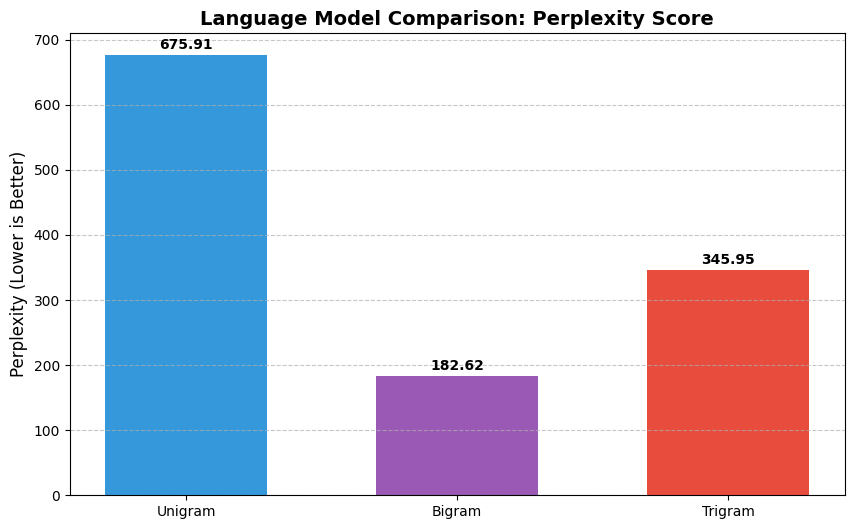

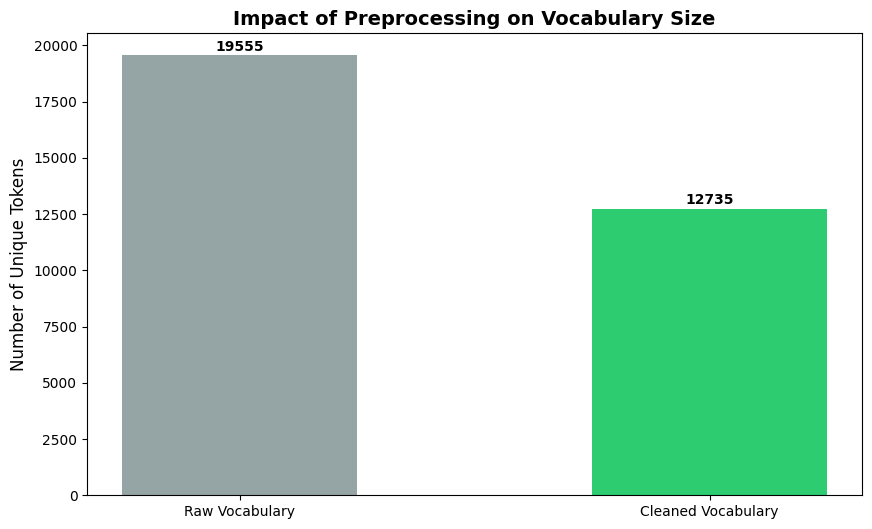

Graphs generated and saved as 'perplexity_comparison.png' and 'vocab_comparison.png'


In [26]:
import matplotlib.pyplot as plt

models = ['Unigram', 'Bigram', 'Trigram']
perp_values = [uni_perp, bi_perp, tri_perp]

plt.figure(figsize=(10, 6))
colors = ['#3498db', '#9b59b6', '#e74c3c']
bars = plt.bar(models, perp_values, color=colors, width=0.6)

plt.title('Language Model Comparison: Perplexity Score', fontsize=14, fontweight='bold')
plt.ylabel('Perplexity (Lower is Better)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom', fontweight='bold')

plt.savefig('perplexity_comparison.png')
plt.show()

vocab_labels = ['Raw Vocabulary', 'Cleaned Vocabulary']
vocab_counts = [raw_vocab, clean_vocab]

plt.figure(figsize=(10, 6))
plt.bar(vocab_labels, vocab_counts, color=['#95a5a6', '#2ecc71'], width=0.5)

plt.title('Impact of Preprocessing on Vocabulary Size', fontsize=14, fontweight='bold')
plt.ylabel('Number of Unique Tokens', fontsize=12)

for i, v in enumerate(vocab_counts):
    plt.text(i, v + (max(vocab_counts)*0.01), str(v), ha='center', fontweight='bold')

plt.savefig('vocab_comparison.png')
plt.show()

print("Graphs generated and saved as 'perplexity_comparison.png' and 'vocab_comparison.png'")